# Lesson 3 Assignment

In this lab assignment, you will implement a simplified version of Random Forest classifier and practice how to use and fine-tune Random Forest, Extra Trees, and Gradient Boosted Trees. You will then compare the model performance of various classifiers on internet ad dataset.

In [51]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features.

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [52]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip')
print(internetAd.info())
internetAd.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


<ipython-input-52-28ceae0b03d7>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip')


,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Question 1: Prepare and impute missing values with the median (missing values for this dataset are \?, nonad. ad.)

In [53]:
internetAd.isna().sum()

internetAd = internetAd.replace({'nonad.': 0, 'ad.': 1})
internetAd = internetAd.replace({'\?': np.NaN}, regex=True)
internetAd.head(10)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
internetAd[internetAd.eq('?').any(axis=1)]
internetAd[internetAd.eq('ad.').any(axis=1)]
internetAd[internetAd.eq('nonad.').any(axis=1)]

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target


In [55]:
meds = internetAd.median()
internetAd = internetAd.fillna(meds)
internetAd.isnull().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
Target                0
Length: 1559, dtype: int64

Question 2: Split dataset into training and test set

In [56]:
from sklearn.model_selection import train_test_split

X = internetAd.iloc[:,:-1]
y = internetAd.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



Question 3: Train and evaluate a randomeforrest classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [57]:
def auroc(y_test, test_z):
  fpr, tpr, threshold = roc_curve(y_test, test_z, drop_intermediate=False) #drop_intermediate=False so we get all thresholds)
  roc_auc = auc(fpr, tpr)
  print("AUC: {}".format(roc_auc))

  # Plot the ROC curve
  import matplotlib.pyplot as plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [58]:
%%time

parameters = {
  "max_depth" : [2, 4],
  "min_samples_split" : [0.05, 0.1, 0.2],
}

rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100 ) #, max_features='sqrt') #, oob_score = True)
rfc.fit(X_train, y_train)

rfc_grid = GridSearchCV(estimator=rfc, param_grid=parameters, cv = 5)
rfc_grid.fit(X_train, y_train)

print(rfc_grid.best_params_) # Hyperparameter tuning

{'max_depth': 4, 'min_samples_split': 0.05}
CPU times: user 26 s, sys: 830 ms, total: 26.8 s
Wall time: 24.3 s


RFC prediction:0.9704524469067405
AUC: 0.9758517898700416


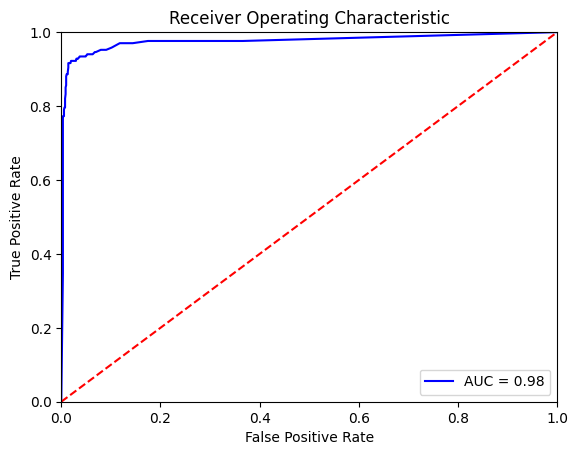

In [59]:
from sklearn.metrics import roc_curve, auc

# make predictions with the trained random forest
test_z = rfc.predict(X_test)
print("RFC prediction:" + str(accuracy_score(y_test, test_z)))

test_z_prob = rfc.predict_proba(X_test)
preds_rfc = test_z_prob[:,1]

auroc(y_test, preds_rfc)

Question 4: Train and evaluate a ExtraTrees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [60]:
%%time

parameters = {
  "max_depth" : [2, 4],
  "min_samples_split" : [0.05, 0.1, 0.2],
}

etc = ExtraTreesClassifier(n_estimators=100)
etc.fit(X_train, y_train)

etc_grid = GridSearchCV(estimator=etc, param_grid=parameters, cv = 5)
etc_grid.fit(X_train, y_train)

print(etc_grid.best_params_)

{'max_depth': 4, 'min_samples_split': 0.1}
CPU times: user 21.2 s, sys: 134 ms, total: 21.3 s
Wall time: 21.4 s


ETC prediction:0.971375807940905
AUC: 0.9776495044844808


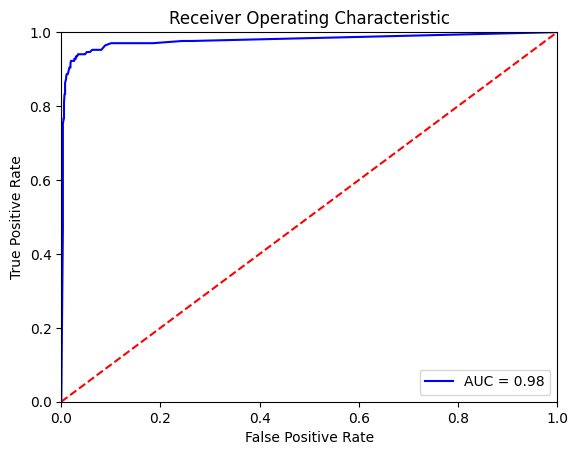

In [61]:
# make predictions with the trained etc
test_z_etc = etc.predict(X_test)
print("ETC prediction:" + str(accuracy_score(y_test, test_z_etc)))

test_z_prob_etc = etc.predict_proba(X_test)
preds_etc = test_z_prob_etc[:,1]

auroc(y_test, preds_etc)
# evaluate the model performance - ACCURACY AND ROC AUC

Question 5: Train and evaluate a Gradient Boosted Trees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [62]:
%%time

parameters = {
  "max_depth" : [2, 4],
  "min_samples_split" : [0.05, 0.1, 0.2],
}

gbt = GradientBoostingClassifier(n_estimators=100)
gbt.fit(X_train, y_train)

gbt_grid = GridSearchCV(estimator=gbt, param_grid=parameters, cv = 5)
gbt_grid.fit(X_train, y_train)

print(gbt_grid.best_params_)

{'max_depth': 4, 'min_samples_split': 0.05}
CPU times: user 2min 4s, sys: 194 ms, total: 2min 4s
Wall time: 2min 5s


GBT prediction:0.971375807940905
AUC: 0.9664709881546949


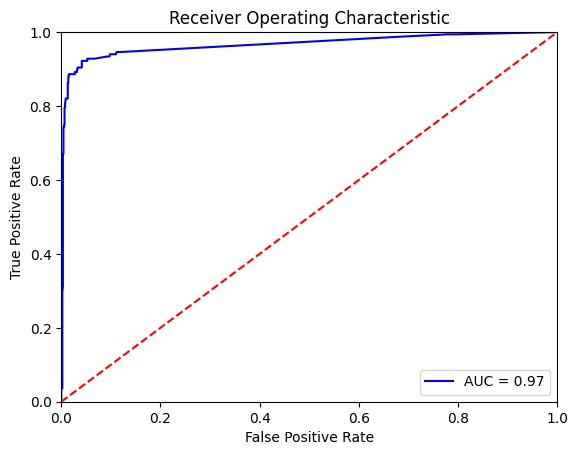

In [63]:
# make predictions with the trained etc
test_z_gbt = etc.predict(X_test)
print("GBT prediction:" + str(accuracy_score(y_test, test_z_gbt)))

test_z_prob_gbt = gbt.predict_proba(X_test)
preds_gbt = test_z_prob_gbt[:,1]

auroc(y_test, preds_gbt)
# evaluate the model performance - ACCURACY AND ROC AUC

[Bonus] Question 6: Which algorithm performed better and why?


Q.6

I ran the notebook in full a few times to check out different results. During my runs I noticed a few similarities:
1. Random Forest was middle of the pack for performance, slightly slower than Extra Trees. I may have specified extra parameters ('sqrt' for example) that made this the case.
2. Extra trees was consistently the most performant model to run.
3. The accuracy of Gradient Boost was highest at first but then was lower.
4. Hyperparameters were stable across all 3 grid searches at first, but during the last run became differentiated.
4. Oddly, on my final run, all three accuracies were very similar. The AUC is slightly higher for Extra Trees though, and therefore I would select it as the best 'performing' model given runtime and AUC/accuracy score.

Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.

Q.7

1. I discussed ensemble models a few times with classmates/peers in the machine learning areas. They seem highly useful versus individual models, despite compute costs.
2. I didn't encounter too many obstacles (which concerns me 😆) this time, and overall thought it was a fine lab to explore the three different RF/ET/GB methods. I referenced my previous lab from 510 to help me grok the AUC/ROC method again.
3. This method is highly applicable to real methods - as we saw with the doctor example in the lecture, but also in other areas such as image classification, facial recognition, climate science, etc. Weak models can be combined to make stronger models/predictions/results.

In [ ]:
%%shell

jupyter nbconvert --to html /content/Lab01.ipynb